In [1]:
import sys
sys.path.append('/home/g/Desktop/git/nodules/src/')
sys.path.append('/home/g/Desktop/git/nodules/keras/')
sys.path.append('/home/g/Desktop/git/nodules/models/')
sys.path.append('/home/g/Desktop/git/keras/keras/preprocessing/')

In [2]:
import os
import copy

In [3]:
from glob import glob

In [4]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [5]:
import seg3d 
import candidates as cd
import candgen as cg

Using TensorFlow backend.


In [6]:
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Convolution3D, MaxPooling3D, UpSampling3D, Dropout
from keras.layers.convolutional import Cropping3D
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import PReLU
from keras.callbacks import ModelCheckpoint

In [7]:
from skimage import feature
from skimage import measure
import skimage

In [8]:
model = seg3d.getModel()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 64, 64, 64) 0                                            
____________________________________________________________________________________________________
conv3d_1 (Conv3D)                (None, 128, 62, 62, 6 3584        input_1[0][0]                    
____________________________________________________________________________________________________
p_re_lu_1 (PReLU)                (None, 128, 62, 62, 6 30505984    conv3d_1[0][0]                   
____________________________________________________________________________________________________
conv3d_2 (Conv3D)                (None, 128, 60, 60, 6 442496      p_re_lu_1[0][0]                  
___________________________________________________________________________________________

In [9]:
model.load_weights('/home/g/Desktop/lowloss_dsb_weights_062017.h5')

In [10]:
datapath = '/scr/nodules/luna/train/subset0/'
annotations = '/home/g/Desktop/git/nodules/resources/annotations.csv'

In [11]:
for parent, subdir, files in os.walk(datapath):
  filelist = glob(parent+'/*.mhd')
  filepathlist = copy.deepcopy(filelist)
templist = []
for f in filelist:
  f = f.split('/')
  f = f[-1]
  templist.append(f[:-4])
filelist = templist
del(templist)

In [12]:
no = 23
candlist = pd.read_csv(annotations)
currentNodules = candlist[candlist['seriesuid'] == filelist[no]]
print currentNodules[['coordX','coordY','coordZ','diameter_mm']]

         coordX     coordY      coordZ  diameter_mm
706  -36.643955 -76.576192 -155.609121    15.282650
707  107.301497  -1.668262 -189.204955    20.035847
708  129.144270  35.495017 -229.664075    22.135331


In [13]:
itk = sitk.ReadImage(filepathlist[no])
image, _ = cg.loadItk(filepathlist[no],None)
origin = np.array(itk.GetOrigin())
spacing = np.array(itk.GetSpacing())
cx = currentNodules['coordX']
cx = cx.as_matrix()
cy = currentNodules['coordY']
cy = cy.as_matrix()
cz = currentNodules['coordZ']
cz = cz.as_matrix()
di = currentNodules['diameter_mm']
di = di.as_matrix()

In [14]:
nno = 0
tcx = cx[nno]
tcy = cy[nno]
tcz = cz[nno]
d = di[nno]
volume = 3.14159265359*(d*d*d/8)*4/3.
center = np.asarray([tcx,tcy,tcz])
newCenter = (center-origin)/spacing
coords = center-origin
coords = np.round(coords).astype(int)

In [15]:
def getSegmentationShape(oldshape):
  factors = (np.asarray(oldshape)/32+2)*32
  return factors

In [16]:
segShape = getSegmentationShape(image.shape)

In [17]:
lpad = (segShape-np.asarray(image.shape))/2
hpad = copy.deepcopy(lpad)

In [18]:
print segShape

[384 480 480]


In [19]:
print image.shape

(332, 440, 440)


In [20]:
print lpad

[26 20 20]


In [21]:
segImage = np.zeros(segShape)

In [22]:
segImage[lpad[0]:segShape[0]-lpad[0],lpad[1]:segShape[1]-lpad[1],lpad[2]:segShape[2]-lpad[2]] = image 

In [23]:
np.sum(segImage)

-50257275501.0

In [24]:
np.sum(image)

-50257275501

In [25]:
stride = 32
strides = copy.deepcopy(segShape)
strides /= stride

In [26]:
print segShape

[384 480 480]


In [27]:
print strides

[12 15 15]


In [28]:
##Try strides of 16 and summing ... 
def segmentImage(image, model, strides, stride=32):
  if stride == 16:
    strides *= 2
  du,dv,dw = strides[0]-1,strides[1]-1,strides[2]-1
  outshape = (du*stride,dv*stride,dw*stride)
  segmentation = np.zeros(outshape)
  for i in range(du):
    print "LAYER " + str(i)
    for j in range(dv):
      for k in range(dw):
        roi = image[i*stride:(i+2)*stride,j*stride:(j+2)*stride,k*stride:(k+2)*stride]
        roi = np.expand_dims(np.expand_dims(roi,axis=0),axis=0)
        output = model.predict(roi, batch_size=1)
        #print output.shape
        #print np.sum(output)
        segmentation[i*stride:(i+1)*stride,j*stride:(j+1)*stride,k*stride:(k+1)*stride] = output
  return segmentation

In [29]:
segImage = np.clip(segImage,-1000,1000)
segImage += 1000
segImage *= (255./2000.)
print np.sum(segImage)

6708426664.49


In [30]:
image = np.clip(image,-1000,1000)
image += 1000
image = image*(255./2000.)
print np.sum(image)

3623130664.48


In [31]:
segmentation = segmentImage(segImage, model, strides, stride)

LAYER 0
LAYER 1
LAYER 2
LAYER 3
LAYER 4
LAYER 5
LAYER 6
LAYER 7
LAYER 8
LAYER 9
LAYER 10


In [32]:
np.sum(segmentation)

5120.5491002441477

In [33]:
tempseg = copy.deepcopy(segmentation)

In [34]:
lpad-=16

In [35]:
np.sum(tempseg[lpad[0]:tempseg.shape[0]-lpad[0],lpad[1]:tempseg.shape[1]-lpad[1],lpad[2]:tempseg.shape[2]-lpad[2]])

5094.5489403967395

In [36]:
seg = tempseg[lpad[0]:tempseg.shape[0]-lpad[0],lpad[1]:tempseg.shape[1]-lpad[1],lpad[2]:tempseg.shape[2]-lpad[2]]

In [37]:
np.sum(seg)

5094.5489403967395

In [38]:
seg[coords[2],coords[1],coords[0]]

1.0

In [39]:
seg = np.where(seg>1e-2,1,0)

In [40]:
labels = measure.label(seg,connectivity=1)

In [41]:
props = measure.regionprops(labels,seg)

In [42]:
len(props)

164

In [43]:
props[0].centroid

(4.0, 124.0, 164.0)

In [106]:
image.shape

(332, 440, 440)

In [107]:
seg.shape

(332, 440, 440)

In [108]:
labels.shape

(332, 440, 440)

In [114]:
seg[coords[2],coords[1],coords[0]]

0.0

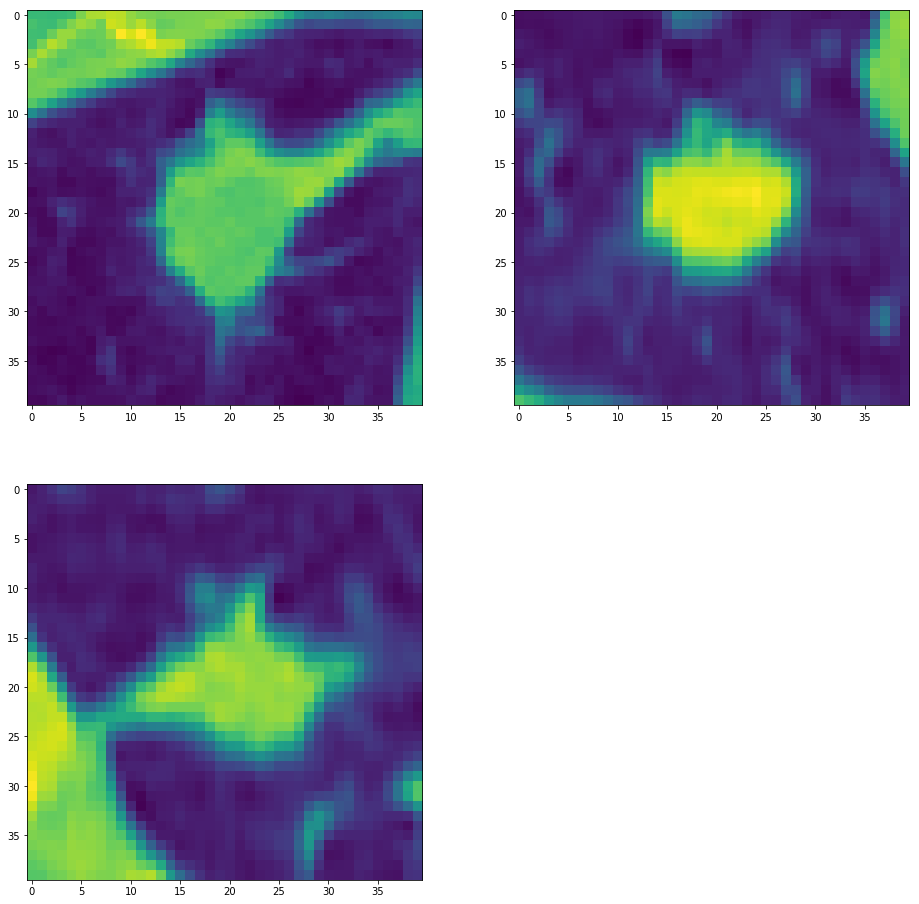

In [120]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(image[coords[2],coords[1]-20:coords[1]+20,coords[0]-20:coords[0]+20])
plt.subplot(222)
plt.imshow(image[coords[2]-20:coords[2]+20,coords[1],coords[0]-20:coords[0]+20])
plt.subplot(223)
plt.imshow(image[coords[2]-20:coords[2]+20,coords[1]-20:coords[1]+20,coords[0]])
plt.show()

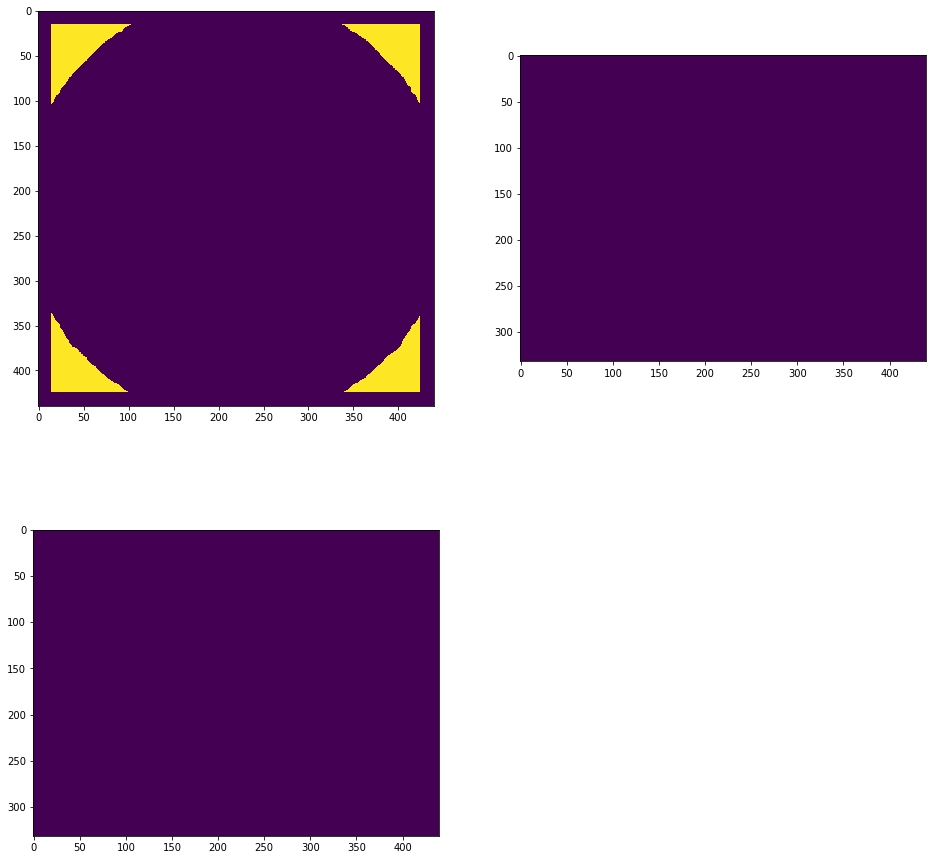

In [162]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(seg[16,:,:])
plt.subplot(222)
plt.imshow(seg[:,coords[1],:])
plt.subplot(223)
plt.imshow(seg[:,:,coords[0]])
plt.show()

In [165]:
labels[labels.shape[0]-17,labels.shape[1]-17,labels.shape[2]-17]

4

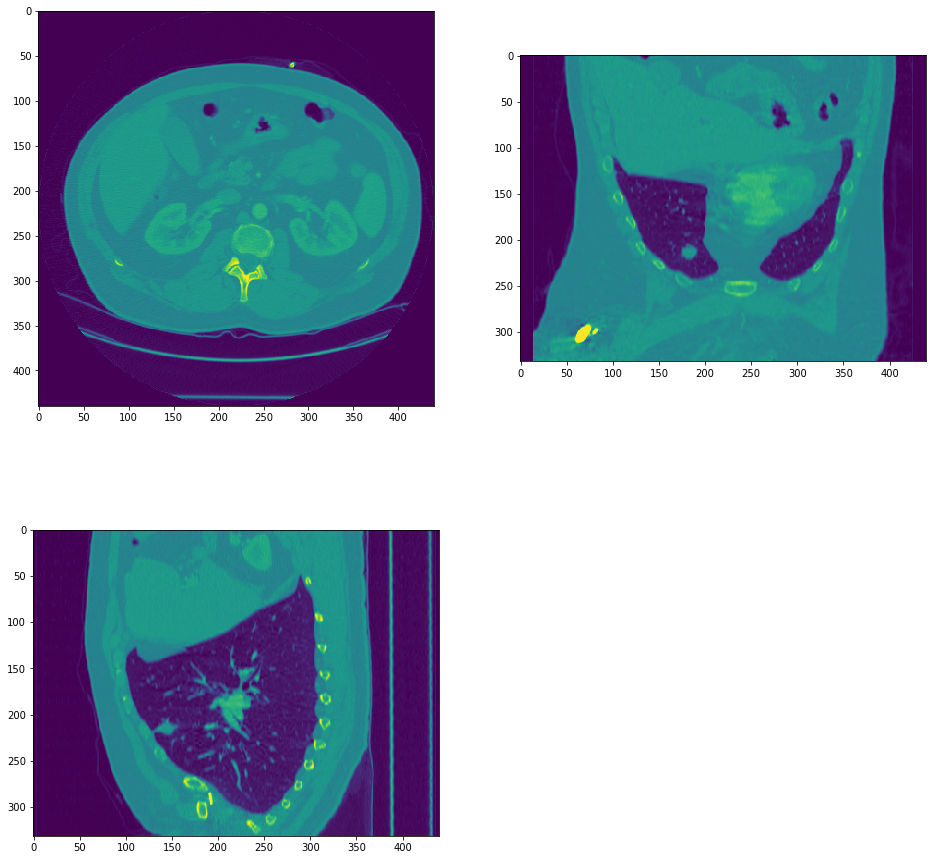

In [166]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(image[16,:,:])
plt.subplot(222)
plt.imshow(image[:,coords[1],:])
plt.subplot(223)
plt.imshow(image[:,:,coords[0]])
plt.show()